In [1]:
import numpy as np
import pandas as pd
from scipy.special import gamma
import quadpy
import orthopy
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
np.random.seed(0)

# Markovian rBergomi

## Gaussian Quadrature Rule

In [4]:
def exp_underflow(x):
    """
    computes exp(-x) avoiding underflow errors
    x: float of numpy array
    """
    if isinstance(x, np.ndarray):
        if x.dtype == int:
            x = x.astype(np.float)
        eps = np.finfo(x.dtype).tiny
    else:
        if isinstance(x, int):
            x = float(x)
        eps = np.finfo(x.__class__).tiny
    log_eps = -np.log(eps) / 2
    result = np.exp(-np.fmin(x, log_eps))
    result = np.where(x > log_eps, 0, result)
    return result

In [5]:
def settings(T, H, N):
    '''
    N : total nodes 
    m: level of Gaussian quadrature rule
    n: number of subintervals
    '''
    N = N - 1
    A = np.sqrt(1 / H + 1 / (1.5 - H))
    
    alpha = 1.06418
    beta = 0.4275
    
    # why float(N) instead of N???
    z = np.exp(alpha*beta)
    factor_1 = ((9 - 6 * H) / (2 * H)) ** (z / (8 * (z - 1)))
    factor_2a = 5*np.pi**3 / 768 * z * (z-1) * (A**(2-2*H)*(3-2*H)) / (beta**(2-2*H)*H) * float(N)**(1-H)
    factor_2b = 5*np.pi**3 / 1152 * z * (z-1) * A**(2-2*H) / beta**(2-2*H) * float(N)**(1-H)
    
    gamma_ = 1 / (3 * z / (8 * (z - 1)) + 6 * H - 4 * H * H)
    a = (1/T) * (factor_1 * factor_2a**(2*H))**gamma_
    b = (1/T) * (factor_1 * factor_2b**(2*H-3))**gamma_
                 
    m = int(np.fmax(np.round(beta / A * np.sqrt(N)), 1))
    n = int(np.round(N / m))

    xi_0 = a * np.exp(-alpha*np.sqrt(N) / ((1.5-H)*A))
    xi_n = b * np.exp(alpha * np.sqrt(N) / (H*A))
    sub_intervals =  np.exp(np.log(xi_0) + np.log(xi_n / xi_0) * np.linspace(0, 1, n + 1))
    return sub_intervals, m

In [6]:
print('subintervals: ', settings(1,0.07,6)[0])
print('m: ', settings(1,0.07,6)[1])

subintervals:  [ 3.68272395  4.93287651  6.60741098  8.85038977 11.85477934 15.87905131]
m:  1


An m-point Gaussian quadrature rule, named after Carl Friedrich Gauss, is a quadrature rule constructed to yield an exact result for polynomials of degree 2m − 1 or less by a suitable choice of the nodes xi and weights wi for i = 1, …, m.

In [7]:
def gauss_quadrature(H, m, a, b):
    '''
    returns the nodes and weights of the Gauss quadrature rule of level m on [a, b]
    '''
    d = np.arange(2 * m) + 0.5 - H
    c_H = 1 / (gamma(0.5 + H) * gamma(0.5 - H))
    alpha, beta, int_1 = orthopy.tools.chebyshev(moments = c_H / d * (b ** d - a ** d))
    return quadpy.tools.scheme_from_rc(alpha, beta, int_1)

In [8]:
def gaussian_optimal_zero_weight(H, T, nodes, weights):
    """
    Computes the optimal weight in the L^2-approximation of an additional node at 0 given that we are already using the
    specified nodes and weights.
    :param H: Hurst parameter
    :param T: Final time
    :param nodes: The nodes of the Markovian approximation, a numpy array
    :param weights: The weights of the Markovian approximation, a numpy array
    :return: The optimal weight in the L^2-sense of an additional node at 0
    """
    if len(nodes) == 0:
        return T ** (H - 0.5) / gamma(H + 1.5)
    return (T ** (H + 0.5) / gamma(H + 1.5) - np.sum(weights / nodes * (1 - exp_underflow(nodes * T)))) / T


def gauss_quadrature_sub_intervals(H, m, subs):
    '''
    returns the nodes and weights of the Gaussian quadrature rule of level m on a subinterval
    '''
    n = len(subs) - 1
    nodes = np.empty(m * n)
    weights = np.empty(m * n)
    for i in range(n):
        new_nodes, new_weights = gauss_quadrature(H, m, subs[i], subs[i + 1])
        nodes[m*i : m*(i + 1)] = new_nodes
        weights[m*i : m*(i + 1)] = new_weights
    return nodes, weights

the nodes and weights in the Gaussian quadrature rule are used to approximate the rough kernel G

In [9]:
def gaussian_quadrature_rule(T, H, N):
    sub_intervals, m = settings(T, H, N)
    n = len(sub_intervals) - 1
    
    if N == 1:
        w_0 = T ** (H - 0.5) / gamma(H + 1.5)
        nodes, weights = np.array([0.]), np.array([w_0])    
    else:
        nodes, weights = np.zeros(m * n + 1), np.empty(m * n + 1)
        nodes[1:], weights[1:] = gauss_quadrature_sub_intervals(H, m, sub_intervals)
        weights[0] =  gaussian_optimal_zero_weight(H, T, nodes[1:], weights[1:])
    index_order = np.argsort(nodes)
    sorted_nodes = nodes[index_order]
    sorted_weights = weights[index_order]
    # when exist more than 1 zero nodes???
    if sorted_nodes[0] > 1e-04:
        nodes_ = np.zeros(len(sorted_nodes) + 1)
        nodes_[1:] = sorted_nodes
        weights_ = np.zeros(len(sorted_weights) + 1)
        weights_[1:] = sorted_weights
        sorted_nodes, sorted_weights = nodes_, weights_
    n_zero_nodes = np.sum(sorted_nodes < 1e-04)
    sorted_nodes[:n_zero_nodes] = 0.
    if n_zero_nodes > 1:
        nodes_ = np.zeros(len(sorted_nodes) - n_zero_nodes + 1)
        nodes_[1:] = sorted_nodes[n_zero_nodes:]
        weights_ = np.zeros(len(sorted_nodes) - n_zero_nodes + 1)
        weights_[0] = np.sum(sorted_weights[:n_zero_nodes])
        weights_[1:] = sorted_weights[n_zero_nodes:]
        sorted_nodes, sorted_weights = nodes_, weights_
    return sorted_nodes, sorted_weights

In [10]:
print('nodes: ', gaussian_quadrature_rule(1, 0.07, 6)[0])
print('weights: ', gaussian_quadrature_rule(1, 0.07, 6)[1])

nodes:  [ 0.          4.29047382  5.74693564  7.69781395 10.31094541 13.81114119]
weights:  [0.97815341 0.16946314 0.19215674 0.21788934 0.24706791 0.28015392]


## Markovian approximation of rough Bergomi

In [11]:
def covariance_matrix(nodes, T, time_steps):
    '''
    compute Cholesky decomposition of the covariance matrix 
    of the Gaussian vector (W_dt, int_0^dt e^(-x_i(dt-s))dW_s)_i=1,..,N
    '''
    dt = T/time_steps
    inner_nodes = nodes[1:]
    sum_nodes = inner_nodes[:,None] + inner_nodes[None, :] 
    N = len(nodes)
    cov_matrix = np.empty((N, N))
    entry = (1 - exp_underflow(dt * inner_nodes)) / inner_nodes
    cov_matrix[0,0] = dt
    cov_matrix[0, 1:] = entry
    cov_matrix[1:,0] = entry
    cov_matrix[1:, 1:] = (1 - exp_underflow(dt*sum_nodes)) / sum_nodes
    
    # cholesky decomposition can only applied for positive definite matrix
    computed_chol = False
    sqrt_cov = None
    while not computed_chol:
        try:
            sqrt_cov = np.linalg.cholesky(cov_matrix)
            computed_chol = True
        except np.linalg.LinAlgError:
            dampening_factor = 0.999
            for i in range(1, N):
                cov_matrix[:i, i] = cov_matrix[:i, i] * dampening_factor ** ((i + 1) / N)
                cov_matrix[i, :i] = cov_matrix[i, :i] * dampening_factor ** ((i + 1) / N)
            computed_chol = False
    return sqrt_cov

In [12]:
def integral(nodes, weights, T, time_steps):
    '''
    compute the integral int_0^t (G_hat(t-s))^2 ds 
    '''
    N = len(nodes)
    dt = T/time_steps
    t_n = np.arange(time_steps) * dt 
    w_0 = weights[0]
    inner_nodes = nodes[1:]
    inner_weights = weights[1:]
    
    weight_mult = inner_weights[np.newaxis,:] * inner_weights[:, np.newaxis]
    node_sum = inner_nodes[np.newaxis, :] + inner_nodes[:, np.newaxis]
    
    integral = np.sum((weight_mult/node_sum)[None,...] * (1 - exp_underflow(node_sum[None,...]*t_n[:,None,None])), axis=(1,2))
 
    variance_w00 = w_0**2 * t_n 
    variance_w0i = w_0 * np.sum((inner_weights/inner_nodes)[np.newaxis,:] * (1 - exp_underflow(inner_nodes[np.newaxis,:]*t_n[:,np.newaxis])), axis=1)

    return integral + variance_w00 + 2*variance_w0i 

In [108]:
def rBergomi_markovian(time_steps, M, nodes, weights, T=1, H=0.07, eta=1.9, rho=-0.9, v0=0.09, S0=100):
    '''
    simulate M paths of stock prices, volatilities by Markovian approximation of rough Bergomi model
    Params: H: Hurst parameter
            T: maturity
            eta: vol of vol
            rho: correlation of 2 Brownian motions
            nodes, weights: nodes and weights of Gaussian quadrature rule
            V0: forward variance constant
            S0: spot price
            M: number of simualted paths
    '''
    dt = T / time_steps
    N = len(nodes)
    sqrt_cov = covariance_matrix(nodes, T, time_steps)

    active_nodes = nodes
    active_weights = weights
    
    if weights[0] == 0:  # this is faster if the zero-node is not used in the volatility process
        active_nodes = nodes[1:]
        active_weights = weights[1:]
    active_N = len(active_nodes)
    dW = np.einsum('ij,kjl->kil', sqrt_cov, np.random.normal(0, 1, size=(M, N, time_steps)))
    W = np.zeros((M, N, time_steps))
    for i in range(time_steps - 1):  # W is Brownian motion, then W_t2 = W_t1 + N(0, dt)
        W[:, :, i + 1] = exp_underflow(dt * active_nodes) * W[:, :, i] + dW[:, -active_N:, i]

    variance = integral(active_nodes, active_weights, T, time_steps)
    c = eta * np.sqrt(2 * H) * gamma(H + 0.5)
    W_int = np.dot(c * active_weights, W)

    v = v0 * np.exp(W_int - 0.5 * c ** 2 * variance)
    
    dWs = rho * dW[:, 0, :] + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt), size=(M, time_steps))
    S = np.zeros((M, time_steps+1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(np.sqrt(v) * dWs - 0.5 * v * dt, axis=1))
    
    s1 = np.zeros((M, time_steps + 1))
    s1[:, 0] = S0
    for i in range(time_steps):
        s1[:, i+1] = s1[:, i] * np.exp(np.sqrt(v[:, i]) * dWs[:, i] - 0.5 * v[:, i] * dt)
    return S, v, s1

In [14]:
H = 0.07 
T = 1 
N = 20
eta = 1.9
rho = -0.9
V0 = 0.09
S0 = 100
r = 0.

discretizing_steps = 128
M = 100000 # number of simulated paths

nodes, weights = gaussian_quadrature_rule(T, H, N)

In [15]:
model = rBergomi_markovian(128, 100000, nodes, weights)  
mk_v = model[1]
mk_s = model[0]
test = model[2]

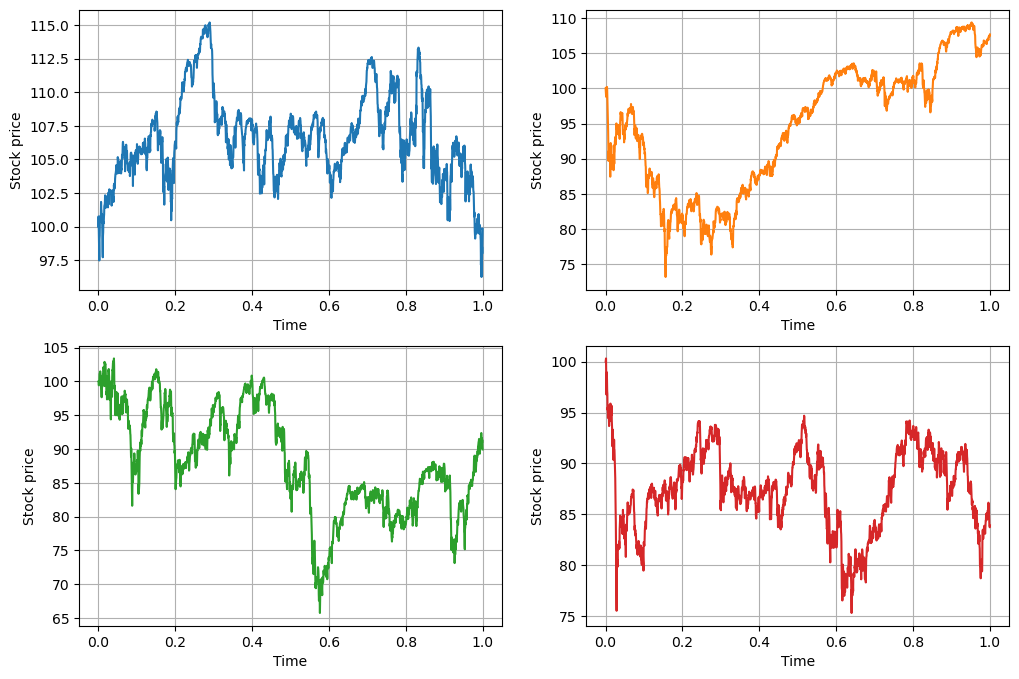

In [27]:
x = np.linspace(0,T,2001)
plt_mk = rBergomi_markovian(2000, 4, nodes, weights)  
y = plt_mk[0]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(x, y[1])
axs[0, 1].plot(x, y[2], 'tab:orange')
axs[1, 0].plot(x, y[3], 'tab:green')
axs[1, 1].plot(x, y[0], 'tab:red')

axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)



for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Stock price')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
    
fig.savefig('fig2')

# non-markovian rBergomi

In [16]:
from scipy.special import hyp2f1, beta

In [17]:
def sqrt_cov_matrix(T, N, H):
    """
    Construct the joint covariance matrix for the Volterra process W̃ 
    and the Brownian motion Z
    and compute its Cholesky decomposition.
    """
    dt = T/N
    cov = np.empty(shape=(2 * N, 2 * N))
    times = np.arange(1, N + 1) * dt
    minima = np.fmin(times[:, None], times[None, :])
    maxima = np.fmax(times[:, None], times[None, :])
    
    cov[0:N, 0:N] = (minima ** (0.5 + H)) * (maxima ** (H - 0.5)) * beta(1, H+0.5) * hyp2f1(0.5 - H, 1, 1.5 + H, minima / maxima)
    cov[N:(2 * N), N:(2 * N)] = minima
    cov[0:N, N:(2 * N)] = 1 / (H + 0.5) * (times[:,None] ** (H + 0.5) - np.fmax(times[:, None] - times[None, :], 0) ** (H + 0.5))
    cov[N:(2 * N), 0:N] = cov[0:N, N:(2 * N)].T
    
    return np.linalg.cholesky(cov)

In [18]:
def rBergomi(time_steps, M, T=1, H=0.07, eta=1.9, rho=-0.9, v0=0.09, S0=100):
    N = time_steps
    dt = T / N
    sqrt_cov = sqrt_cov_matrix(T, time_steps, H)
    W_int = (sqrt_cov @ np.random.randn(2*N, M)).T
    
    t = np.linspace(0, T, N+1)[None, 1:-1]
    
    v = np.zeros((M, N))  # actual V is of shape (M, N+1), but we do not need the last one for S
    v[:, 0] = v0
    v[:, 1:] = v0 * np.exp(eta * np.sqrt(2*H) * W_int[:,:N - 1] - 0.5 * eta**2 * t**(2*H))
    
    dW1 = np.zeros((M, N))
    dW1[:, 0] = W_int[:, N]
    dW1[:, 1:] = W_int[:, N+1:] - W_int[:, N:2 * N - 1]
    dZ = rho * dW1 + np.random.normal(0, np.sqrt(1 - rho ** 2) * np.sqrt(dt), (M, N))
    
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(np.sqrt(v) * dZ - 0.5 * v * dt, axis=1))
    return S, v

In [19]:
rB_model = rBergomi(128, 100000)
rb_v = rB_model[1]
rb_s = rB_model[0]

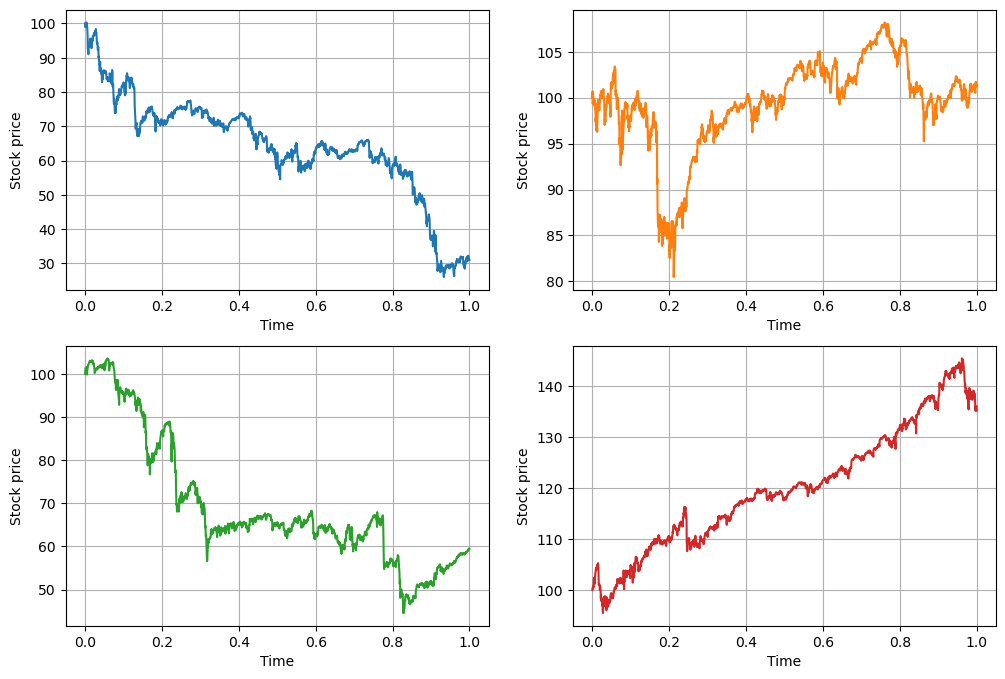

In [26]:
x = np.linspace(0,T,2001)
plt_rb = rBergomi(2000, 4)
y = plt_rb[0]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(x, y[1])
axs[0, 1].plot(x, y[2], 'tab:orange')
axs[1, 0].plot(x, y[3], 'tab:green')
axs[1, 1].plot(x, y[0], 'tab:red')

axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)



for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Stock price')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
    
fig.savefig('fig1')

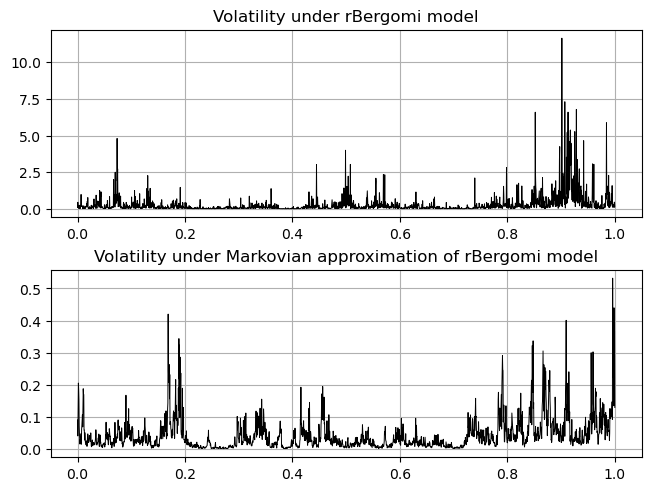

In [29]:
x = np.linspace(0,T,2000)
y1 = plt_rb[1][1]
y2 = plt_mk[1][1]

fig, ax = plt.subplots(2, 1, constrained_layout=True)
#fig.suptitle('Axes values are scaled individually by default')
ax[0].plot(x, y1, linewidth = 0.7, c = 'black')
ax[0].set_title('Volatility under rBergomi model')
ax[0].grid(True)
ax[1].plot(x, y2, linewidth = 0.7, c = 'black')
ax[1].set_title('Volatility under Markovian approximation of rBergomi model')
ax[1].grid(True)

fig.savefig('fig3')

# European Put 

In [30]:
#eur_premia = np.array([12.45, 15.33, 18.64, 22.40, 26.54, 30.97, 35.61, 40.39, 45.25, 50.17])

In [115]:
model = rBergomi_markovian(128, 100000, nodes, weights)  
mk_v = model[1]
mk_s = model[0]
test = model[2]

In [97]:
rB_model = rBergomi(128, 100000)
rb_v = rB_model[1]
rb_s = rB_model[0]

In [134]:
def european_put(S, K, T=1, r=0.05):
    payoffs = np.fmax(K-S[:,-1], 0)
    discounted_h = payoffs * np.exp(-r * T)
    return np.round(np.average(discounted_h),4)

In [135]:
# European put price by Markovian approximation
for k in range(70, 150, 10):
    print('Strike ',k,': markov: ', european_put(mk_s, k), european_put(test, k), 'non-markov: ', european_put(rb_s, k))

Strike  70 : markov:  2.1507 2.1507 non-markov:  2.1238
Strike  80 : markov:  3.6738 3.6738 non-markov:  3.6387
Strike  90 : markov:  6.0163 6.0163 non-markov:  5.9862
Strike  100 : markov:  9.474 9.474 non-markov:  9.4938
Strike  110 : markov:  14.3867 14.3867 non-markov:  14.5098
Strike  120 : markov:  20.9681 20.9681 non-markov:  21.2503
Strike  130 : markov:  29.064 29.064 non-markov:  29.4273
Strike  140 : markov:  38.094 38.094 non-markov:  38.4088


In [117]:
K = np.arange(70, 150, 10)
l = len(K)
premia = ['-', '-', '-', '-', 15.33, 22.40, 30.97, 40.39]
mk_eur = np.zeros(l)
rb_eur = np.zeros(l)
for i in range(l):
    mk_eur[i] = european_put(mk_s, K[i])
    rb_eur[i] = european_put(rb_s, K[i])

In [61]:
mk_eur = [2.23, 3.84, 6.29, 9.85, 14.81, 21.34, 29.34, 38.32]
rbergomi_eur = [2.13, 3.65, 6.00, 9.51, 14.52, 21.26, 29.44, 38.40]
rbergomi_simon = [2.10, 3.61, 5.96, 9.49, 14.52, 21.28, 29.46, 38.44]
premia = ['-', '-', '-', '-', 15.33, 22.40, 30.97, 40.39]

In [62]:
data = {'markovian': mk_eur, 'non-markovian': rb_eur, 'premia': premia}

In [63]:
df1 = pd.DataFrame(data, columns = ['markovian', 'non-markovian', 'premia'], index = K)

In [64]:
df1['relative error markov - nonmarkov'] = df1['markovian'] / df1['non-markovian'] - 1 

In [65]:
df1

,markovian,non-markovian,premia,relative error markov - nonmarkov
70,2.23,2.2267,-,0.001482
80,3.84,3.8329,-,0.001852
90,6.29,6.3048,-,-0.002347
100,9.85,9.9884,-,-0.013856
110,14.81,15.2765,15.33,-0.030537
120,21.34,22.3632,22.4,-0.045754
130,29.34,30.9570,30.97,-0.052234
140,38.32,40.3962,40.39,-0.051396


## American Put

In [136]:
# American put price under markovian approximation
mk_put_eur = []
mk_4 = []
mk_8 = []
mk_16 = []
mk_32 = []
for k in np.arange(70, 150, 10):
    #print(k)
    mk_put_eur.append(european_put(mk_s, k))
    mk_4.append(longstaff_schwartz_multivariate(mk_s, mk_v, 4, k)[0])
    mk_8.append(longstaff_schwartz_multivariate(mk_s, mk_v, 8, k)[0])
    mk_16.append(longstaff_schwartz_multivariate(mk_s, mk_v, 16, k)[0])
    mk_32.append(longstaff_schwartz_multivariate(mk_s, mk_v, 32, k)[0])
    #print('PutEur: ', european_put(mk_s, k)) 
    #print('8 Ausübungszeiten: ', 'PutAmer by univariate Regression: ', longstaff_schwartz(mk_s, 8, k, dimension=6)[0], '|| PutAmer by multivariate Regression: ', longstaff_schwartz_multivariate(mk_s, mk_v, 8, k)[0])
    #print('16 Ausübungszeiten: ', 'PutAmer by univariate Regression: ', longstaff_schwartz(mk_s, 16, k, dimension=6)[0], '|| PutAmer by multivariate Regression: ', longstaff_schwartz_multivariate(mk_s, mk_v, 16, k)[0])
    #print('________')

In [137]:
# put price by rough Bergomi
rb_put_eur = []
rb_4 = []
rb_8 = []
rb_16 = []
rb_32 = []
for k in np.arange(70, 150, 10):
    rb_put_eur.append(european_put(rb_s, k))
    rb_4.append(longstaff_schwartz_multivariate(rb_s, rb_v, 4, k)[0])
    rb_8.append(longstaff_schwartz_multivariate(rb_s, rb_v, 8, k)[0])
    rb_16.append(longstaff_schwartz_multivariate(rb_s, rb_v, 16, k)[0])
    rb_32.append(longstaff_schwartz_multivariate(rb_s, rb_v, 32, k)[0])

In [138]:
data_ma = {'mkEurPut': mk_put_eur,
    'mk_4': mk_4,
    'mk_8': mk_8,
    'mk_16': mk_16,
    'mk_32': mk_32,
    'rbEurPut': rb_put_eur,
    'rb_4': rb_4,
    'rb_8': rb_8,
    'rb_16': rb_16,
    'rb_32': rb_32}

df_2 = pd.DataFrame(data_ma, index=np.arange(70, 150, 10))

In [139]:
df_2.T

,70,80,90,100,110,120,130,140
mkEurPut,2.1507,3.6738,6.0163,9.4740,14.3867,20.9681,29.0640,38.0940
mk_4,2.2560,3.8627,6.3268,9.9696,15.1548,22.1006,30.6088,40.1644
mk_8,2.2664,3.8706,6.3220,9.9913,15.1683,22.1123,30.6601,40.1632
mk_16,2.2708,3.8724,6.3232,9.9732,15.1576,22.0724,30.6538,40.1907
mk_32,2.2736,3.8690,6.3142,9.9576,15.1533,22.0730,30.6033,40.1889
rbEurPut,2.1238,3.6387,5.9862,9.4938,14.5098,21.2503,29.4273,38.4088
rb_4,2.2351,3.8248,6.2950,9.9783,15.2467,22.3332,30.9577,40.4165
rb_8,2.2379,3.8299,6.2980,9.9769,15.2607,22.3588,30.9819,40.4407
rb_16,2.2364,3.8310,6.2987,9.9846,15.2743,22.3464,30.9560,40.4133
rb_32,2.2429,3.8427,6.3020,9.9815,15.2753,22.3496,30.9536,40.4210


In [140]:
for ls in [mk_put_eur,mk_4,mk_8,mk_16,mk_32,rb_put_eur,rb_4,rb_8,rb_16,rb_32]:
    print(" & ".join([str(np.round(i,2)) for i in ls]) + "   \\")

2.15 & 3.67 & 6.02 & 9.47 & 14.39 & 20.97 & 29.06 & 38.09   \
2.26 & 3.86 & 6.33 & 9.97 & 15.15 & 22.1 & 30.61 & 40.16   \
2.27 & 3.87 & 6.32 & 9.99 & 15.17 & 22.11 & 30.66 & 40.16   \
2.27 & 3.87 & 6.32 & 9.97 & 15.16 & 22.07 & 30.65 & 40.19   \
2.27 & 3.87 & 6.31 & 9.96 & 15.15 & 22.07 & 30.6 & 40.19   \
2.12 & 3.64 & 5.99 & 9.49 & 14.51 & 21.25 & 29.43 & 38.41   \
2.24 & 3.82 & 6.3 & 9.98 & 15.25 & 22.33 & 30.96 & 40.42   \
2.24 & 3.83 & 6.3 & 9.98 & 15.26 & 22.36 & 30.98 & 40.44   \
2.24 & 3.83 & 6.3 & 9.98 & 15.27 & 22.35 & 30.96 & 40.41   \
2.24 & 3.84 & 6.3 & 9.98 & 15.28 & 22.35 & 30.95 & 40.42   \


In [141]:
# American put price under markovian approximation MC error
mk_put_eur = []
mk_4 = []
mk_8 = []
mk_16 = []
mk_32 = []
for k in np.arange(70, 150, 10):
    #print(k)
    mk_put_eur.append(european_put(mk_s, k))
    mk_4.append(longstaff_schwartz_multivariate(mk_s, mk_v, 4, k)[1])
    mk_8.append(longstaff_schwartz_multivariate(mk_s, mk_v, 8, k)[1])
    mk_16.append(longstaff_schwartz_multivariate(mk_s, mk_v, 16, k)[1])
    mk_32.append(longstaff_schwartz_multivariate(mk_s, mk_v, 32, k)[1])
    
# put price by rough Bergomi
rb_put_eur = []
rb_4 = []
rb_8 = []
rb_16 = []
rb_32 = []
for k in np.arange(70, 150, 10):
    rb_put_eur.append(european_put(rb_s, k))
    rb_4.append(longstaff_schwartz_multivariate(rb_s, rb_v, 4, k)[1])
    rb_8.append(longstaff_schwartz_multivariate(rb_s, rb_v, 8, k)[1])
    rb_16.append(longstaff_schwartz_multivariate(rb_s, rb_v, 16, k)[1])
    rb_32.append(longstaff_schwartz_multivariate(rb_s, rb_v, 32, k)[1])
    
data_mc = {'mkEurPut': mk_put_eur,
    'mk_4': mk_4,
    'mk_8': mk_8,
    'mk_16': mk_16,
    'mk_32': mk_32,
    'rbEurPut': rb_put_eur,
    'rb_4': rb_4,
    'rb_8': rb_8,
    'rb_16': rb_16,
    'rb_32': rb_32}

df_3 = pd.DataFrame(data_mc, index=np.arange(70, 150, 10))    

In [142]:
df_3.T

,70,80,90,100,110,120,130,140
mkEurPut,2.150700,3.673800,6.016300,9.474000,14.386700,20.968100,29.064000,38.094000
mk_4,0.048229,0.065109,0.082358,0.100352,0.116926,0.125611,0.129083,0.124502
mk_8,0.047674,0.064235,0.080698,0.097432,0.112930,0.123532,0.129613,0.128339
mk_16,0.047118,0.063519,0.079571,0.094693,0.109476,0.119694,0.126027,0.121241
mk_32,0.046375,0.062059,0.077641,0.092290,0.105243,0.114338,0.116520,0.114588
rbEurPut,2.123800,3.638700,5.986200,9.493800,14.509800,21.250300,29.427300,38.408800
rb_4,0.048526,0.064822,0.083898,0.103242,0.122211,0.135539,0.141318,0.143435
rb_8,0.048325,0.064219,0.083365,0.102489,0.121092,0.133139,0.140053,0.139397
rb_16,0.047213,0.063257,0.081645,0.102014,0.118791,0.128600,0.132777,0.134794
rb_32,0.047367,0.064213,0.082152,0.099088,0.115726,0.124508,0.127919,0.129940


In [146]:
np.array(mk_put_eur) / np.array(rb_put_eur) - 1

array([ 0.01266598,  0.0096463 ,  0.00502823, -0.00208557, -0.00848392,
       -0.01327981, -0.01234568, -0.00819604])

In [147]:
np.array(mk_4) / np.array(rb_4) - 1

array([-0.00612449,  0.00443259, -0.01835401, -0.02798746, -0.0432414 ,
       -0.07324344, -0.08657462, -0.13199105])

In [148]:
np.array(mk_8) / np.array(rb_8) - 1

array([-0.01346   ,  0.00024489, -0.03199278, -0.04933551, -0.06739874,
       -0.07215779, -0.07454662, -0.07932714])

In [149]:
np.array(mk_16) / np.array(rb_16) - 1

array([-0.00201234,  0.00414747, -0.02541208, -0.07176607, -0.07842116,
       -0.06925066, -0.05084137, -0.10054148])

In [150]:
np.array(mk_32) / np.array(rb_32) - 1

array([-0.02093948, -0.03353871, -0.05490729, -0.06860479, -0.09058239,
       -0.08167966, -0.08911256, -0.1181462 ])

In [105]:
# put price by markovian approximation
data_us_mk = {'EurPut': mk_put_eur,
    'uni_8': mk_uni_8,
    'uni_16': mk_uni_16,
    'multi_8': mk_multi_8,
    'multi_16': mk_mutli_16}

df_us_mk = pd.DataFrame(data_us_mk, index=np.arange(70, 150, 10))

In [106]:
df_us_mk.T

,70,80,90,100,110,120,130,140
EurPut,2.3115,3.951,6.458,10.1339,15.318,22.2557,30.7883,40.2863
uni_8,2.3307,3.9669,6.4807,10.1554,15.3406,22.273,30.8083,40.2961
uni_16,2.3361,3.976,6.4854,10.1667,15.3493,22.2675,30.8154,40.285
multi_8,"(2.3299, 0.0467557539815071)","(3.9658, 0.06414106403553295)","(6.475, 0.08377779298827794)","(10.156, 0.10471050766120756)","(15.333, 0.123882635568629)","(22.251, 0.1351963948910728)","(30.8081, 0.14226043076194636)","(40.2906, 0.13433016167914338)"
multi_16,"(2.337, 0.04611083021846945)","(3.9771, 0.06317597570595751)","(6.4838, 0.08296737792770806)","(10.1654, 0.10418981984929634)","(15.3425, 0.12203741684202732)","(22.2457, 0.13206154328210248)","(30.7833, 0.13799245671686705)","(40.2657, 0.12250934668095625)"


In [ ]:
#eur_premia = np.array([12.45, 15.33, 18.64, 22.40, 26.54, 30.97, 35.61, 40.39, 45.25, 50.17])

# Longstaff-Schwartz 

## univariate

In [66]:
def longstaff_schwartz(stockprice, exercise_dates, K, dimension=5, T=1, r=0.):
    M = stockprice.shape[0]
    J = stockprice.shape[1] - 1
    N = exercise_dates
    dt = T / N
    n = J // N  # discretizing steps per period
    
    if n * N != J:
        raise Exception("Error: number of exercise dates and number of steps per period do not match!")
    
    S = stockprice[:,::int(n)] 
    payoff = np.fmax(K-S, 0)
    stop = np.full(M, N)
    #itm0 = np.where(payoff[:,N] > 0)[0]
    #stop[itm0] = N
    cf = np.zeros((M, N+1))
    cont_array = np.zeros((M,N+1))
    stop_array = np.full(shape=(M,N+1), fill_value = 0)
    coeff_array = []
    for i in range(N, 0, -1):
        itm = np.where(payoff[:,i-1] > 0)[0]
        if len(itm) == 0:
            pass
        else:
            x = S[:,i-1][itm]
            y = payoff[itm, stop[itm]] * np.exp(-r * dt * (stop[itm]-i+1))
            coeffs = np.polyfit(x, y, dimension)
            coeff_array.insert(0,coeffs)
            cont = np.zeros(M)
            cont[itm] = np.polyval(coeffs, x) 
            cont_array[itm, i-1] = np.polyval(coeffs, x) 
            exercise = payoff[:,i-1]
            early_ex = np.where(exercise >= cont)[0]
            intersect = np.intersect1d(itm, early_ex)
            stop[intersect] = i-1
            stop_array[intersect, i-1] = 1 
    #paths = np.where(stop < np.inf)[0]
    #ls = [int(i) for i in stop[paths]]
    disc_payoff = payoff[np.arange(M), stop] * np.exp(-r * dt * stop)
    p = np.mean(disc_payoff)
    mc_err = 1.96 * np.std(disc_payoff) / np.sqrt(M)
    return np.round(p, 4), mc_err #, disc_payoff, stop, cont_array, stop_array, coeff_array #"Monte Carlo Error: {:%}".format(mc_err)

## multivariate

In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [133]:
def longstaff_schwartz_multivariate(stockprice, volatility, exercise_dates, K, dimension='m2', T=1, r=0.):
    M = stockprice.shape[0]
    J = stockprice.shape[1] - 1
    N = exercise_dates
    dt = T / N
    n = J // N  # discretizing steps per period
    
    if n * N != J:
        raise Exception("Error: number of exercise dates and number of steps per period do not match!")
    
    S = stockprice[:,::int(n)] 
    v = volatility[:,::int(n)]
    payoff = np.fmax(K-S, 0)
    stop = np.full(M, N)

    cf = np.zeros((M, N+1))
    cont_array = np.zeros((M,N+1))
    stop_array = np.full(shape=(M,N+1), fill_value = 0)
    coeff_array = []
    for i in range(N, 0, -1):
        itm = np.where(payoff[:,i-1] > 0)[0]
        if len(itm) == 0:
            pass
        else:
            x1 = S[:,i-1][itm]
            x2 = v[:,i-1][itm]
            y = payoff[itm, stop[itm]] * np.exp(-r * dt * (stop[itm]-i+1))
            j = len(itm)
            if dimension == 'm1':
                X_1 = np.vstack((np.ones(j), x1, x2, x1**2, x1*x2))
            if dimension == 'm2':
                X_1 = np.vstack((np.ones(j), x1, x2, x1**2, x1**3, x1**4, x1**5, x1**6, x1*x2))
            if dimension == 'm3':
                X_1 = np.vstack((np.ones(j), x1, x2, x1**2, x1*x2, x1**2 * x2, x1**3))

            X = X_1.T #transform
            regModel = LinearRegression()
            regModel.fit(X, y) # fit the model

            # get expected continuation values
            cont = np.zeros(M)
            cont[itm] = regModel.predict(X) 
            cont_array[itm, i-1] = regModel.predict(X)  
            
            exercise = payoff[:,i-1]
            early_ex = np.where(exercise >= cont)[0]
            intersect = np.intersect1d(itm, early_ex)
            stop[intersect] = i-1
            stop_array[intersect, i-1] = 1 
    disc_payoff = payoff[np.arange(M), stop] * np.exp(-r * dt * stop)
    p = np.mean(disc_payoff)
    mc_err = 1.96 * np.std(disc_payoff) / np.sqrt(M)
    return np.round(p, 4), mc_err

# Option Prices Experiments

In [ ]:
H = 0.07 
T = 1  
eta = 1.9
rho = -0.9
V0 = 0.09
S0 = 100
r = 0.05
N = 6
time_steps = 500
M = 500000 # number of simulated paths

In [ ]:
# Markovian approximation of rBergomi model
model_markov = rBergomi_markovian(H, T, eta, rho, nodes, weights, time_steps, V0, S0, M)

In [ ]:
# Rough Bergomi model
model_rB = rBergomi(H, T, time_steps, M, S0, V0, rho, eta)

In [ ]:
# stock price paths and volatility paths
stp_mk = model_markov[0]
vol_mk = model_markov[1]
stp_rB = model_rB[0]
vol_rB = model_rB[1]

In [ ]:
K = np.arange(70, 160, 10)
l = len(K)

eur_mk = np.zeros(l)
eur_rB = np.zeros(l)

for k in range(l):
    eur_mk[k] = european_put(1, stp_mk, K[k])
    eur_rB[k] = european_put(1, stp_rB, K[k])

In [ ]:
eur_mk

In [ ]:
eur_rB